[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/your-username/your-repo/blob/main/your-notebook.ipynb)


# 1. Overview & Learning Outcomes

**Learning objectives**
- Explain the classical NLP pipeline: preprocessing → representation → features → modeling → evaluation.
- Use spaCy for tokenization, stopword handling, and lemmatization.
- Build Bag-of-Words and TF-IDF representations (with unigrams/bigrams).
- Extract POS tags and named entities.
- Train simple text classifiers and evaluate them (accuracy, precision/recall/F1, confusion matrix).
- (Optional) Visualize TF-IDF spaces with TruncatedSVD.

This notebook focuses on **traditional text processing** methods that work well with classical ML models such as
Naive Bayes, Logistic Regression, and SVM.



# 2. Setup & Imports

**Learning objectives**
- Ensure required libraries are installed and imported.
- Load `en_core_web_sm` (download if not present).
- Keep runtime light and deterministic.

> Notes: Use matplotlib only for plots (no seaborn). Each figure is a single plot.


In [4]:

# Guarded installs (run once if needed)
# import sys, subprocess, importlib

# def ensure(pkg):
#     try:
#         importlib.import_module(pkg)
#     except ImportError:
#         print("Installing", pkg)
#         subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])

# for pkg in ["spacy", "scikit-learn", "matplotlib", "pandas", "numpy"]:
#     ensure(pkg)

import random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy.cli import download as spacy_download

# Determinism where possible
random.seed(7)
np.random.seed(7)

# Load or download small English model
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    print("Downloading spaCy en_core_web_sm...")
    spacy_download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

print("spaCy version:", spacy.__version__)
print("Model loaded:", nlp.meta.get("name", "unknown"))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.3 MB/s  0:00:01 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
spaCy version: 3.8.7
Model loaded: core_web_sm



# 3. Text Preprocessing with spaCy

**Learning objectives**
- Tokenize, lowercase, remove stopwords, and lemmatize.
- Build a small, in-notebook corpus and inspect token frequencies.


In [5]:

# A tiny corpus across 3 topics (tech, travel, food) + mild noise
docs = [
    # tech
    "Machine learning improves systems automatically from data.",
    "C++ and Python interoperate; GPUs accelerate deep learning workloads.",
    "Read our API docs at https://example.com/docs for usage notes.",
    # travel
    "Bali beaches were amazing and the sunsets were unforgettable!",
    "We booked flights via email and chatted with @travel_helper.",
    "Paris in spring is not too crowded; museums were delightful.",
    # food
    "The ramen was so good, but not cheap. I'd still recommend it!",
    "Try our menu and promotions at http://noodles.example/ — so tasty!",
    "I dislike overly sweet desserts; they're not my style."
]

labels = [
    "tech","tech","tech",
    "travel","travel","travel",
    "food","food","food"
]

import pandas as pd
df = pd.DataFrame({"text": docs, "label": labels})
df


,text,label
0,Machine learning improves systems automaticall...,tech
1,C++ and Python interoperate; GPUs accelerate d...,tech
2,Read our API docs at https://example.com/docs ...,tech
3,Bali beaches were amazing and the sunsets were...,travel
4,We booked flights via email and chatted with @...,travel
5,Paris in spring is not too crowded; museums we...,travel
6,"The ramen was so good, but not cheap. I'd stil...",food
7,Try our menu and promotions at http://noodles....,food
8,I dislike overly sweet desserts; they're not m...,food



### Tokenization, Stopwords, Lemmatization

We implement a small utility that:
- lowercases
- optionally removes stopwords
- optionally lemmatizes
- keeps only alphabetic tokens when desired


In [6]:

from spacy.lang.en.stop_words import STOP_WORDS

def spacy_tokenize(text, *, lemmatize=True, remove_stopwords=True, lower=True, keep_alpha=True):
    doc = nlp(text)
    out = []
    for t in doc:
        tok = t.lemma_ if lemmatize else t.text
        if lower:
            tok = tok.lower()
        if keep_alpha and not tok.isalpha():
            continue
        if remove_stopwords and tok in STOP_WORDS:
            continue
        out.append(tok)
    return out

# Demo on one document
sample = df.text.iloc[0]
print("Original:", sample)
print("Processed tokens:", spacy_tokenize(sample))


Original: Machine learning improves systems automatically from data.
Processed tokens: ['machine', 'learning', 'improve', 'system', 'automatically', 'datum']



### Token Frequency Histogram

We count top terms after basic preprocessing and show a single-plot bar chart.


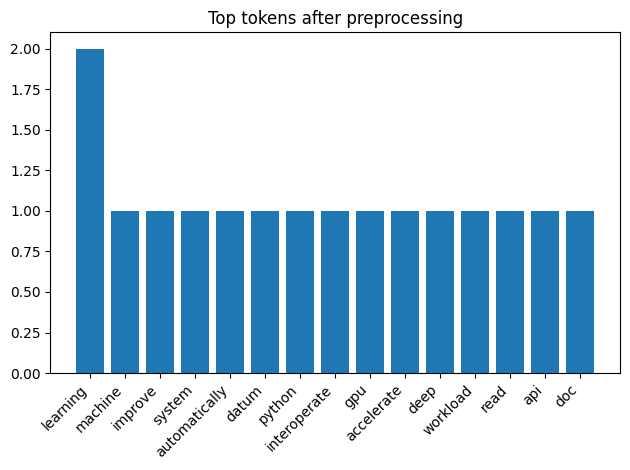

In [7]:

from collections import Counter

all_tokens = []
for s in df.text:
    all_tokens.extend(spacy_tokenize(s))

freqs = Counter(all_tokens)
top = freqs.most_common(15)
labels_bar = [w for w,_ in top]
values_bar = [c for _,c in top]

plt.figure()
plt.bar(range(len(labels_bar)), values_bar)
plt.xticks(range(len(labels_bar)), labels_bar, rotation=45, ha="right")
plt.title("Top tokens after preprocessing")
plt.tight_layout()
plt.show()



# 4. Statistical Representations: BoW, N-grams, TF-IDF

**Learning objectives**
- Build CountVectorizer (BoW) and TfidfVectorizer.
- Compare unigrams vs bigrams, vocabulary size, and sparsity.


In [8]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Wrapper for scikit-learn vectorizers
def tokenizer_wrapper(text):
    return spacy_tokenize(text, lemmatize=True, remove_stopwords=True, lower=True, keep_alpha=True)

X_count_uni = CountVectorizer(tokenizer=tokenizer_wrapper, ngram_range=(1,1))
X_count_bi  = CountVectorizer(tokenizer=tokenizer_wrapper, ngram_range=(1,2))
X_tfidf_bi  = TfidfVectorizer(tokenizer=tokenizer_wrapper, ngram_range=(1,2))

Xc_uni = X_count_uni.fit_transform(df.text)
Xc_bi  = X_count_bi.fit_transform(df.text)
Xt_bi  = X_tfidf_bi.fit_transform(df.text)

def density(mat):
    return mat.nnz / (mat.shape[0] * mat.shape[1])

print("BoW unigrams:", Xc_uni.shape, "density:", round(density(Xc_uni), 4))
print("BoW uni+bi :", Xc_bi.shape,  "density:", round(density(Xc_bi), 4))
print("TF-IDF uni+bi:", Xt_bi.shape, "density:", round(density(Xt_bi), 4))

# Show a few feature names
print("Sample TF-IDF features:", X_tfidf_bi.get_feature_names_out()[:20])


BoW unigrams: (9, 44) density: 0.1136
BoW uni+bi : (9, 80) density: 0.1125
TF-IDF uni+bi: (9, 80) density: 0.1125
Sample TF-IDF features: ['accelerate' 'accelerate deep' 'amazing' 'amazing sunset' 'api' 'api doc'
 'automatically' 'automatically datum' 'bali' 'bali beach' 'beach'
 'beach amazing' 'book' 'book flight' 'chat' 'cheap' 'cheap recommend'
 'crowd' 'crowd museum' 'datum']


/Users/rudyhendrawan/Codes/unstructured-data/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



### Inspect Top TF-IDF Terms per Document


In [9]:

import numpy as np

feature_names = X_tfidf_bi.get_feature_names_out()

def top_k_tfidf(doc_index, k=8):
    row = Xt_bi[doc_index].toarray().ravel()
    idx = np.argsort(-row)[:k]
    return [(feature_names[i], float(row[i])) for i in idx if row[i] > 0]

for i in range(3):
    print(f"Doc {i}:", top_k_tfidf(i, k=8))


Doc 0: [('learning improve', 0.30551801610656915), ('machine', 0.30551801610656915), ('improve system', 0.30551801610656915), ('improve', 0.30551801610656915), ('machine learning', 0.30551801610656915), ('automatically', 0.30551801610656915), ('automatically datum', 0.30551801610656915), ('system automatically', 0.30551801610656915)]
Doc 1: [('accelerate', 0.280459111172371), ('python interoperate', 0.280459111172371), ('python', 0.280459111172371), ('learning workload', 0.280459111172371), ('interoperate gpu', 0.280459111172371), ('gpu accelerate', 0.280459111172371), ('gpu', 0.280459111172371), ('deep learning', 0.280459111172371)]
Doc 2: [('note', 0.3333333333333333), ('usage', 0.3333333333333333), ('usage note', 0.3333333333333333), ('api', 0.3333333333333333), ('api doc', 0.3333333333333333), ('read', 0.3333333333333333), ('read api', 0.3333333333333333), ('doc', 0.3333333333333333)]



# 5. Linguistic Features: POS & NER (spaCy)

**Learning objectives**
- Extract part-of-speech tags and named entities.
- Understand when these can be useful in traditional pipelines.


In [10]:

sent = "Paris in spring is not too crowded; museums were delightful."
doc = nlp(sent)

print("POS tags (token, POS, head):")
for t in doc:
    print(f"{t.text:12s} {t.pos_:6s} -> {t.head.text}")

print("\nNamed Entities (text, label):")
for ent in doc.ents:
    print(ent.text, ent.label_)


POS tags (token, POS, head):
Paris        PROPN  -> is
in           ADP    -> is
spring       NOUN   -> in
is           AUX    -> were
not          PART   -> is
too          ADV    -> crowded
crowded      VERB   -> is
;            PUNCT  -> were
museums      NOUN   -> were
were         AUX    -> were
delightful   ADJ    -> were
.            PUNCT  -> were

Named Entities (text, label):
Paris GPE
spring DATE



# 6. From Features to Models: A Simple Text Classifier

**Learning objectives**
- Train two classical pipelines and compare:
  1) CountVectorizer(1,2) + LogisticRegression
  2) TfidfVectorizer(1,2) + LinearSVC
- Evaluate with accuracy, precision, recall, F1 (macro) and a confusion matrix.


Results on test split:
BoW+LR -> acc=0.333, P=0.111, R=0.333, F1=0.167
TF-IDF+LinearSVC -> acc=0.333, P=0.111, R=0.333, F1=0.167


/Users/rudyhendrawan/Codes/unstructured-data/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/rudyhendrawan/Codes/unstructured-data/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


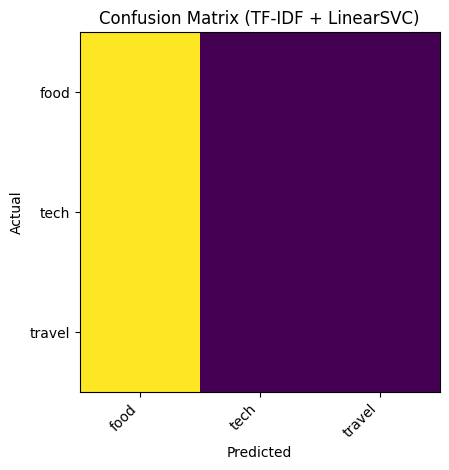

In [11]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    df.text, df.label, test_size=0.33, random_state=7, stratify=df.label
)

pipe1_vec = CountVectorizer(tokenizer=tokenizer_wrapper, ngram_range=(1,2))
X1_train = pipe1_vec.fit_transform(X_train)
X1_test  = pipe1_vec.transform(X_test)
clf1 = LogisticRegression(max_iter=1000)
clf1.fit(X1_train, y_train)
p1 = clf1.predict(X1_test)

pipe2_vec = TfidfVectorizer(tokenizer=tokenizer_wrapper, ngram_range=(1,2))
X2_train = pipe2_vec.fit_transform(X_train)
X2_test  = pipe2_vec.transform(X_test)
clf2 = LinearSVC()
clf2.fit(X2_train, y_train)
p2 = clf2.predict(X2_test)

def report(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"{name} -> acc={acc:.3f}, P={pr:.3f}, R={rc:.3f}, F1={f1:.3f}")

print("Results on test split:")
report(y_test, p1, "BoW+LR")
report(y_test, p2, "TF-IDF+LinearSVC")

# Confusion matrix for the better model (pick p2 here for demo)
labels_sorted = sorted(df.label.unique())
cm = confusion_matrix(y_test, p2, labels=labels_sorted)

plt.figure()
plt.imshow(cm)
plt.xticks(range(len(labels_sorted)), labels_sorted, rotation=45, ha="right")
plt.yticks(range(len(labels_sorted)), labels_sorted)
plt.title("Confusion Matrix (TF-IDF + LinearSVC)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



# 7. Dimensionality Reduction & Visualization (Optional)

**Learning objectives**
- Reduce TF-IDF vectors to 2D with TruncatedSVD (LSA).
- Scatter plot documents colored by class (matplotlib defaults).


/Users/rudyhendrawan/Codes/unstructured-data/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


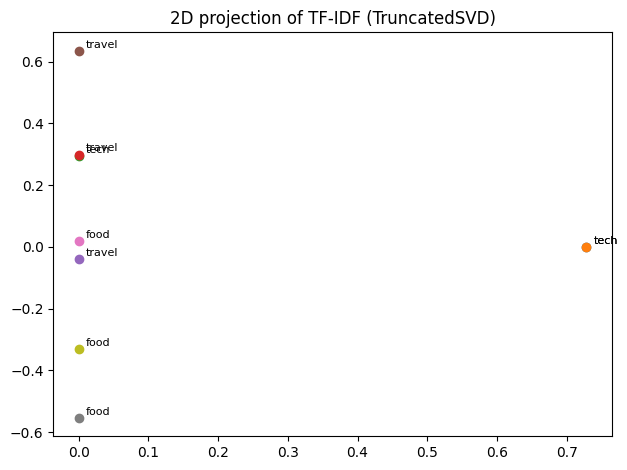

In [12]:

from sklearn.decomposition import TruncatedSVD

Xt_all = X_tfidf_bi.fit_transform(df.text)
svd = TruncatedSVD(n_components=2, random_state=7)
Z = svd.fit_transform(Xt_all)

# Map labels to integers for color grouping (matplotlib default color cycle)
label_to_int = {lab:i for i,lab in enumerate(sorted(df.label.unique()))}
colors = [label_to_int[l] for l in df.label]

plt.figure()
for i, (x, y) in enumerate(Z):
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, df.label[i], fontsize=8)
plt.title("2D projection of TF-IDF (TruncatedSVD)")
plt.tight_layout()
plt.show()



# 8. Common Pitfalls & Best Practices

- **Data leakage**: Always fit preprocessing/vectorizers on **training** data only.
- **Over-aggressive cleaning**: Removing negators or meaningful punctuation can harm sentiment tasks.
- **Too many n-grams**: High-order n-grams increase sparsity and overfitting.
- **Domain specificity**: Build custom stopword lists; general lists may be inadequate.
- **Reproducibility**: Fix seeds and document preprocessing configs.



# 9. Mini Review & Next Steps

**Review questions**
1. When is TF-IDF preferable to raw counts?
2. Give two cases where removing stopwords is **not** a good idea.
3. What trade-offs exist between lemmatization and stemming?
4. Why can bigrams improve a classifier? When might they hurt?
5. What are some signals POS or NER can add to classical models?

**Next steps**
- Topic modeling (LDA) on TF-IDF spaces.
- Word embeddings (Word2Vec/GloVe) and hybrid pipelines.
- Modern encoders (BERT-family) for context-aware features.
